# Kernel Regression

Given a training dataset $\{x_i, y_i\}_{i=1}^n$, kernel regression approximates the unknown 
nolinear relation between $x$ and $y$ with a function of form
$$
y\approx f(x;w) = \sum_{i=1}^n w_i k(x, x_i),
$$
where $k(x, x')$ is a positive definite kernel specified by the users, and ${w_i}$ is a
set of weights. 
We will use the simple Gaussian radius basis funciton (RBF) kernel,
$$
k(x, x') = exp(-\frac{||x-x'||^2}{2h^2}),
$$
where $h$ is a bandwith parameter. 


### Step 1. Simulate a 1-dimensional dataset

xTrain shape (100, 1) yTrain shape (100, 1)


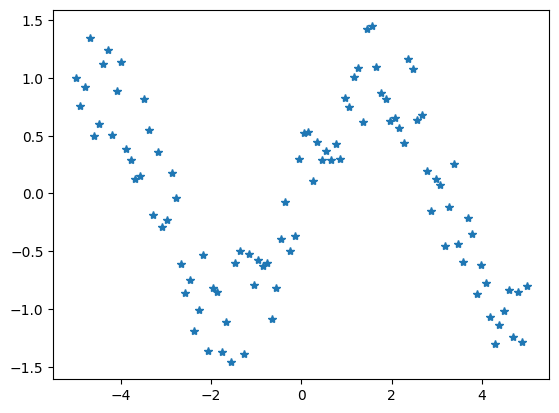

In [2]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)

### Step 1: Simulate a simple 1D data ###
xTrain = np.expand_dims(np.linspace(-5, 5, 100), 1)  # 100*1
yTrain = np.sin(xTrain) + 0.5*np.random.uniform(-1, 1, size=xTrain.shape) ## 100 *1

print('xTrain shape', xTrain.shape, 'yTrain shape', yTrain.shape)
plt.plot(xTrain, yTrain, '*')
plt.show()

Now we have a dataset with 100 training data points. Let us calculate the kernel function. 

### Step 2. Kernel function

Your task is to complete the following rbf_kernel function that takes two sets of points $X$ (of size $n$) and $X'$ (of size $m$) and the bandwidth $h$ and ouputs their pairwise  kernel matrix $K = [k(x_i, x_j)]_{ij}$, which is of size $n\times m$. We will represent input data as matrices, with $X=[x_i]_{i=1}^n \in R^{n\times 1}$ denoting the input features and $Y=[y_i]_{i=1}^n\in R^{n\times 1}$ the input labels.)

In [3]:
import math
from scipy.spatial import distance


"""
    calcuating kernel matrix between X and Xp
"""
def rbf_kernel(X, Xp, h):
    # X: n*1 matrix
    # Xp: m*1 matrix
    # h: scalar value 
                
    ## TODO: please calculate the kernel matrix in the following:  
    # (hint: you can write your own pairwise distance function, or cipy.spatial.distance.cdist)
    dists = distance.cdist(X, Xp, 'euclidean')

    numerator = np.power(dists, 2.0)
    denominator = 2 * math.pow(h, 2.0)
    inner_part = -(numerator / denominator)
    K = np.exp(inner_part)
            
    return K #n*m



### evaluation: if your implementation is correct, you should expect the output is a 2X3 matrix
# [[0.60653066 1.         0.60653066]
# [0.13533528 0.60653066 1.        ]]
k_test = rbf_kernel(np.array([[2],[1]]), np.array([[3],[2],[1]]), 1)
print(k_test)
    

[[0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]


### Step 3. The median trick for bandwith
The choice of the bandwidth $h$
A common way to set the bandwith $h$ in practice is the so called median trick,
which sets $h$ to be the median of the pairwise distance on the training data, that is
$$
h_{med} = median(\{||x_i - x_j||: i\neq j, ~~~~~~i,j =1, ..., n\}).
$$

- Task: Compelete the median distance function. 


In [4]:
from scipy.spatial import distance

def median_distance(X):
    # X: n*1 matrix
     
    # Calculates the median of the pairwise distance of $X$ below 
    #(hint: use '[dist[i, j] for i in range(len(X)) for j in range(len(X)) if i != j]' to remove the diagonal terms; use np.median)
    
    pw_dists = []  # pairwise distances
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if i != j:
                pw_dists.append(np.linalg.norm(X[i] - X[j]))
    h = np.median(pw_dists)
    
    return h


### Test your functions
#evaluation: if your implementation is correct, your answer should be [2.0]
h_test = median_distance(np.array([[1],[2],[4]]))
print(h_test)

2.0


### Step 4. Kernel regression
The weights ${w_i}$ are estimated by minimizing a regularized mean square error:
$$
\min_w {\left ( \sum_{i=1}^n (y_i - f(x_i; w))^2 \right) + \beta w^\top K w },     
$$
where $w$ is the column vector formed by $w=[w_i]_{i=1}^n$ and K is the kernel matrix.

- Please derive the optimal solution of $w$ using matrix inverseion (no need to show the work) 

- Complete the following function to implement the calculation of $w$ 

In [5]:
def kernel_regression_fitting(xTrain, yTrain, h, beta=1):
    # X: input data, numpy array, n*1
    # Y: input labels, numpy array, n*1

    n = len(xTrain)
    W = np.zeros((n, 1))
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            K[i][j] = np.exp(-((xTrain[i] - xTrain[j]) ** 2) / (2 * h ** 2))
 
    # calculate W below (it is a n*1 matrix) using matrix inversion
    W = np.dot(np.linalg.inv(K + beta * np.identity(n)), yTrain)
  
    return W

### evaluating your code, the shape should be (100, 1) (check the values yourself)
h = median_distance(xTrain)
W_test = kernel_regression_fitting(xTrain, yTrain, h)
print(W_test.shape)

(100, 1)


### Step 5. Evaluation and Cross Validation

We now need to evaluate the algorithm on the testing data and select the hyperparameters (bandwidth and regularization coefficient) using cross validation

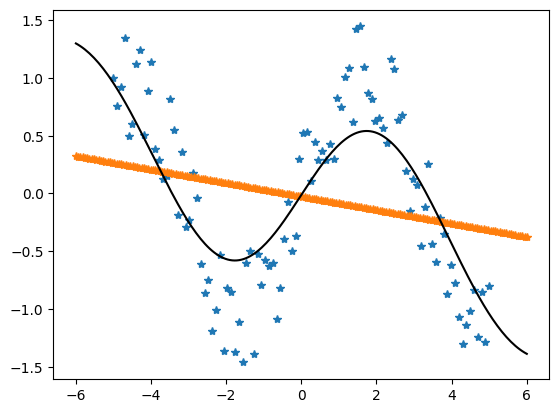

In [6]:
# Please run and read the following base code 

def kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h, beta):
    
    #fitting on the training data 
    W = kernel_regression_fitting(xTrain, yTrain, h, beta)
    
    # computing the kernel matrix between xTrain and xTest
    K_xTrain_xTest = rbf_kernel(xTrain, xTest, h)
   
    # predict the label of xTest
    yPred = np.dot( K_xTrain_xTest.T, W)
    return yPred

# generate random testing data
xTest = np.expand_dims(np.linspace(-6, 6, 200), 1) ## 200*1


beta = 1.
# calculating bandwith
h_med = median_distance(xTrain)  
yHatk = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h_med, beta)


# we also add linear regression for comparision
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(xTrain, yTrain)  
yHat = lr.predict(xTest) # prediction

# visulization
plt.plot(xTrain, yTrain, '*')
plt.plot(xTest, yHat, '*')
plt.plot(xTest, yHatk, '-k')
plt.show()



### Step 5.1. Impact of bandwith 
Run the kernel regression with regularization coefficient $\beta=1$ and 
bandwidth $h \in \{ 0.1 h_{med}, h_{med}, 10h_{med}\}$.

- Task: Show the curve learned by different $h$. Comment on how $h$ influences the smoothness of $h$.


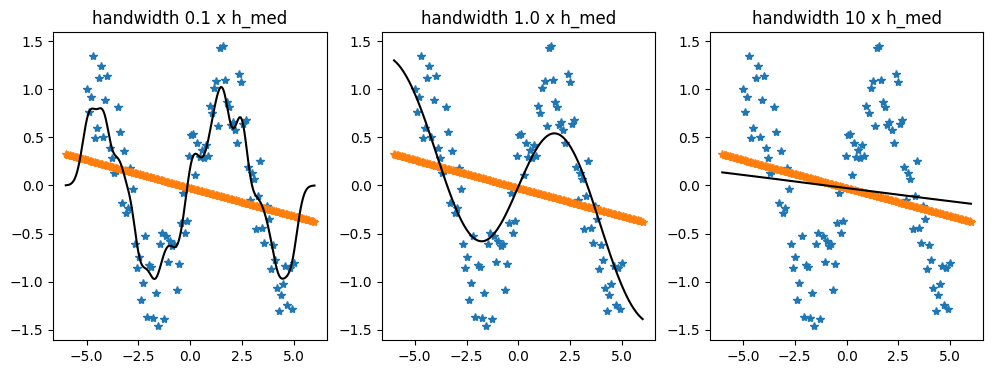

In [7]:
### fitting on the training data ###
beta = 1.

plt.figure(figsize=(12, 4))
for i, coff in enumerate([0.1, 1., 10]):
    plt.subplot(1, 3, i+1)
    
    ### run kernel regression with bandwith h = coff * h_med. 
    yHatk_i = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, (coff * h_med), beta)
    
    # visualization
    plt.plot(xTrain, yTrain, '*')
    plt.plot(xTest, yHat, '*')
    plt.plot(xTest, yHatk_i, '-k')
    plt.title('handwidth {} x h_med'.format(coff))
    
plt.show()


### Step 5.2. Cross Validation (CV)
Use 5-fold cross validation to find the optimal combination of 
$h$ and $\beta$ within $h\in \{0.1h_{med}, h_{med}, 10h_{med}\}$ and $\beta \in \{0.1, 1\}$.
- Task: complete the code of cross validation and find the best $h$ and $\beta$. Plot the curve fit with the optimal hyperparameters.

Beta beta 1 Best bandwith 0.1*h_med mse 0.11166229355896191


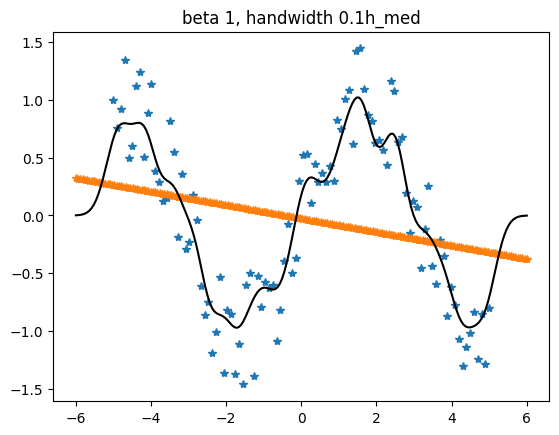

In [24]:
best_beta, best_coff = 1., 1.
best_mse = 1e8
for beta in [0.1, 1]:
    for coff in [0.1, 1., 10.]:
        # 5-fold cross validation
        max_fold = 5
        mse = []
        for i in range(max_fold):
            
            ##TODO: calculate the index of the training/testing partition within 5 fold CV.
            # (hint: set trnIdx to be these index with idx%max_fold!=i, and testIdx with idx%max_fold==i)

            trainingIndexList = [idx for idx in range(len(xTrain)) if idx % max_fold != i]
            testIndexList = [idx for idx in range(len(xTrain)) if idx % max_fold == i]

            i_xTrain, i_yTrain = xTrain[trainingIndexList], yTrain[trainingIndexList]
            i_xValid, yValid_i = xTrain[testIndexList], yTrain[testIndexList]
            
            ##TODO: run kernel regression on (i_xTrain, i_yTrain) and calculate the mean square error on (i_xValid, i_yValid)
            h = (coff * h_med)

            i_yPred = kernel_regression_fit_and_predict(i_xTrain, i_yTrain, i_xValid, h, beta)

            mse.append((yValid_i - i_yPred)**2)
            
        mse = np.mean(mse)
        
        # keep track of the combination with the best MSE
        if mse < best_mse:
            best_beta, best_coff = beta, coff
            best_mse = mse
        
print('Beta beta', best_beta, 'Best bandwith', '{}*h_med'.format(best_coff), 'mse', best_mse)

# bandwith
h = best_coff * median_distance(xTrain)  
yHatk_i = kernel_regression_fit_and_predict(xTrain, yTrain, xTest, h, best_beta)
    
# visualization
plt.plot(xTrain, yTrain, '*')
plt.plot(xTest, yHat, '*')
plt.plot(xTest, yHatk_i, '-k')
plt.title('beta {}, bandwidth {}h_med'.format(best_beta, best_coff))
plt.show()

The best beta was found to be 1 and the best bandwidth was 0.

In [25]:
# The best beta was found to be 1 and the best bandwidth was 0.